### Eigen vectors

In [ ]:
import numpy as np
import sympy as sp

# Define symbolic variables
eps, t, delta = sp.symbols('eps t delta', real=True)

# Define the 6x6 symbolic matrix (example structure, adjust as needed)
H_sym = sp.Matrix([
    [eps,     t,      0,      0,      delta,  0],
    [t,       eps,    t,     -delta,  0,      delta],
    [0,       t,      eps,    0,     -delta,  0],
    [0,      -delta,  0,     -eps,   -t,      0],
    [delta,   0,     -delta, -t,     -eps,   -t],
    [0,       delta,  0,      0,     -t,     -eps]
])

# Function to compute eigenvalues and eigenvectors
def compute_eigen(H, eps_val=None, t_val=None, delta_val=None):
    if eps_val is not None and t_val is not None and delta_val is not None:
        # Numerical substitution
        H_num = H.subs({eps: eps_val, t: t_val, delta: delta_val}).evalf()
        H_np = np.array(H_num).astype(np.complex128)
        eigvals, eigvecs = np.linalg.eig(H_np)
        print("Numerical eigenvalues:")
        print(eigvals)
        print("\nNumerical eigenvectors (columns):")
        print(eigvecs)
    else:
        # Symbolic computation
        eigvals = H.eigenvals()
        eigvecs = H.eigenvects()
        print("Symbolic eigenvalues:")
        for val, mult in eigvals.items():
            print(f"{val} (multiplicity {mult})")
        print("\nSymbolic eigenvectors:")
        for val, mult, vecs in eigvecs:
            print(f"Eigenvalue: {val}")
            for v in vecs:
                sp.pprint(v)

# === Example usage ===
# For symbolic solution
compute_eigen(H_sym)

# For numerical solution
# compute_eigen(H_sym, eps_val=1.0, t_val=0.5, delta_val=0.3)


Symbolic eigenvalues:
-sqrt(delta**2 + eps**2) (multiplicity 1)
sqrt(delta**2 + eps**2) (multiplicity 1)
-sqrt(delta**2 + eps**2 - 2*sqrt(2)*eps*t + 2*t**2) (multiplicity 1)
-sqrt(delta**2 + eps**2 + 2*sqrt(2)*eps*t + 2*t**2) (multiplicity 1)
sqrt(delta**2 + eps**2 - 2*sqrt(2)*eps*t + 2*t**2) (multiplicity 1)
sqrt(delta**2 + eps**2 + 2*sqrt(2)*eps*t + 2*t**2) (multiplicity 1)

Symbolic eigenvectors:
Eigenvalue: -sqrt(delta**2 + eps**2)
⎡          ___________ ⎤
⎢         ╱  2      2  ⎥
⎢ eps   ╲╱  δ  + eps   ⎥
⎢ ─── - ────────────── ⎥
⎢  δ          δ        ⎥
⎢                      ⎥
⎢          0           ⎥
⎢                      ⎥
⎢           ___________⎥
⎢          ╱  2      2 ⎥
⎢  eps   ╲╱  δ  + eps  ⎥
⎢- ─── + ──────────────⎥
⎢   δ          δ       ⎥
⎢                      ⎥
⎢          -1          ⎥
⎢                      ⎥
⎢          0           ⎥
⎢                      ⎥
⎣          1           ⎦
Eigenvalue: sqrt(delta**2 + eps**2)
⎡          ___________ ⎤
⎢         ╱  2      2  ⎥

### Single body formulation

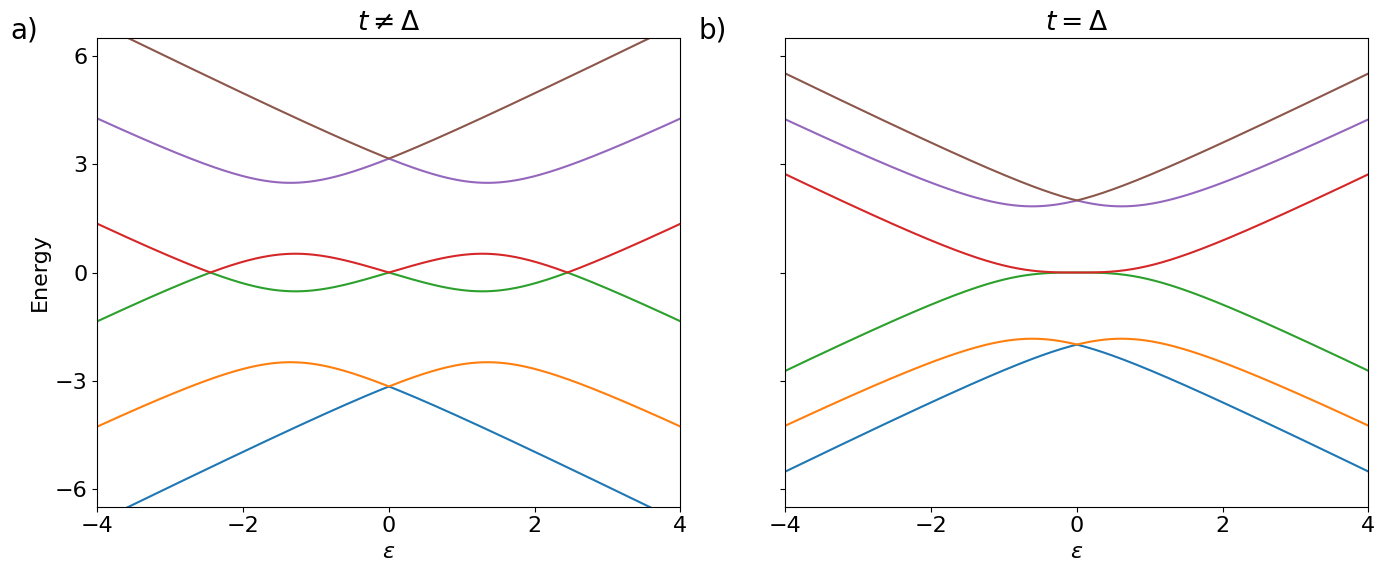

Figure saved as figures_minimal/energy_spectrum_three_site_comparison.pdf


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Define the Hamiltonian ---
def hamiltonian(epsilon1, epsilon2, epsilon3, t, Delta):
    """
    Defines the 3-site Bogoliubov-de Gennes Hamiltonian matrix.
    """
    d = Delta
    return np.array([
        [ epsilon1,     t,       0,       0,     d,     0],
        [ t,       epsilon2,     t,      -d,     0,     d],
        [ 0,            t, epsilon3,      0,    -d,     0],
        [ 0,           -d,       0, -epsilon1,  -t,     0],
        [ d,            0,      -d,     -t, -epsilon2, -t],
        [ 0,            d,       0,      0,    -t, -epsilon3]
    ])

# --- Compute eigenvalues and eigenvectors ---
def compute_eigensystem(epsilon1, epsilon2, epsilon3, t, Delta):
    H = hamiltonian(epsilon1, epsilon2, epsilon3, t, Delta)
    eigvals, eigvecs = np.linalg.eig(H)
    idx = np.argsort(eigvals)
    return np.real(eigvals[idx]), np.real(eigvecs[:, idx])

# --- Define the cases to compare ---
cases = [
    {'t': 2, 'delta': 1, 'label': 'a', 'title': r'$t \neq \Delta$'},
    {'t': 1, 'delta': 1, 'label': 'b', 'title': r'$t = \Delta$'}
]

# --- Plotting Setup ---
plt.rcParams.update({"font.size": 16})
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

epsilon_vals = np.linspace(-5, 5, 400)

# --- Plot each case ---
for ax, case in zip(axes, cases):
    t_val = case['t']
    delta_val = case['delta']
    label = case['label']
    title = case['title']

    # Compute energy bands
    bands = [compute_eigensystem(eps, eps, eps, t_val, delta_val)[0] for eps in epsilon_vals]
    bands = np.array(bands)

    # Plot all six energy bands
    for i in range(bands.shape[1]):
        ax.plot(epsilon_vals, bands[:, i])

    # Axis formatting
    ax.set_title(title)
    ax.set_xlabel(r'$\varepsilon$')
    ax.set_xlim(-4, 4)
    ax.text(-0.15, 1.0, f'{label})', transform=ax.transAxes, size=20)
    ax.set_xticks([-4, -2, 0, 2, 4])

# --- Global formatting ---
axes[0].set_ylabel('Energy')
axes[0].set_ylim(-6.5, 6.5)
axes[0].set_yticks([-6, -3, 0, 3, 6])
plt.tight_layout()

# --- Save the figure ---
save_dir = "figures_minimal"
os.makedirs(save_dir, exist_ok=True)
filename = os.path.join(save_dir, "energy_spectrum_three_site_comparison.pdf")
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as {filename}")
